# 特征工程

In [4]:
import pandas as pd
import seaborn as sns
import scipy.sparse as sp
from sklearn import ensemble
from sklearn.decomposition import TruncatedSVD
from matplotlib import pyplot as plt
import matplotlib
ZHFONT = matplotlib.font_manager.FontProperties(fname="data/SourceHanSansSC-Regular.otf")

# df_members = pd.read_csv("data/members.csv")
df_train = pd.read_csv("data/train.csv")
df_songs = pd.read_csv("data/songs.csv")
df_songs_extra = pd.read_csv("data/song_extra_info.csv")

# 将train，songs和songs_extra进行内连接
df_train = df_train.merge(df_songs,on="song_id",how="inner")
df_train = df_train.merge(df_songs_extra,on="song_id",how="inner")

## 绘制特征热力图

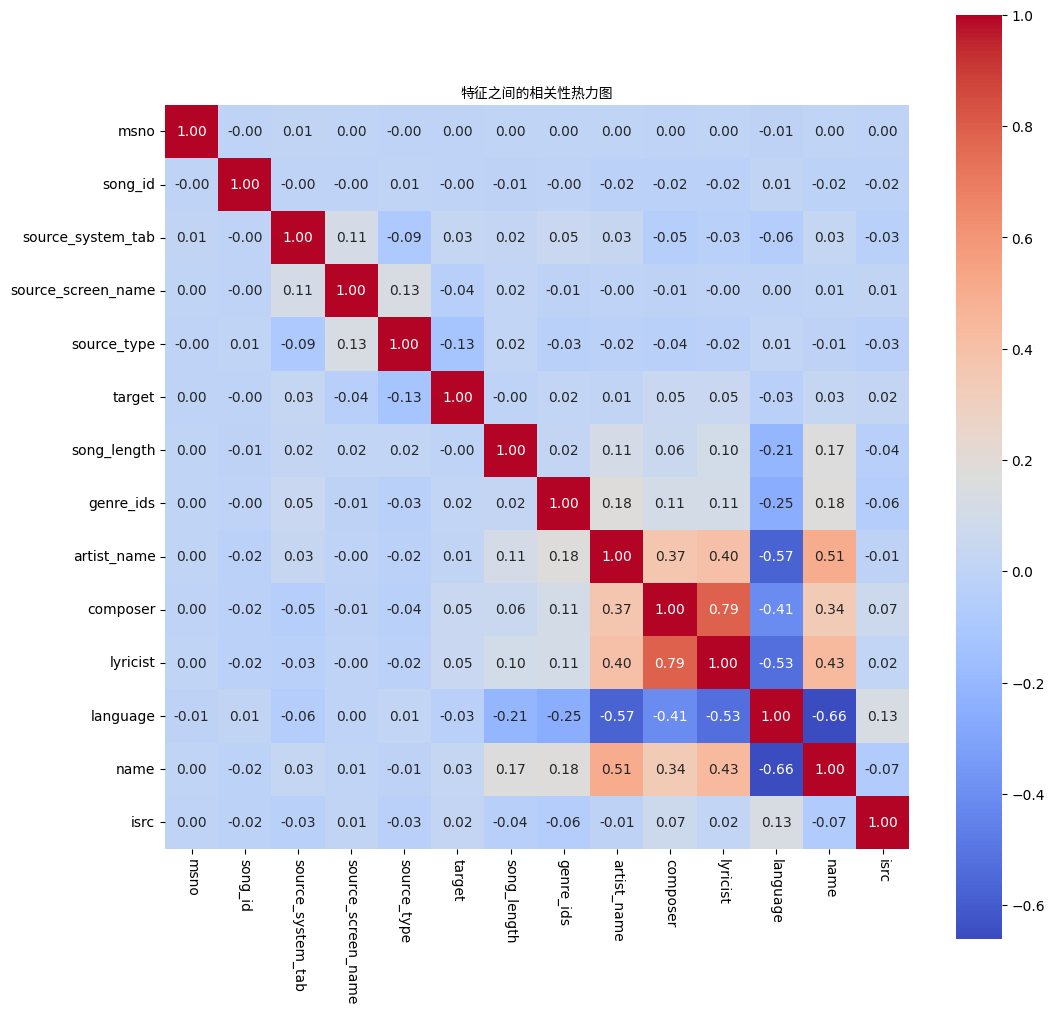

In [5]:
# 将文本类别转换成 Category以计算相关性
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col] = df_train[col].astype('category')
    df_train[col] = df_train[col].cat.codes
corr = df_train.corr()
# 绘制热力图
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar=True)
plt.xticks(rotation = -90)
plt.title('特征之间的相关性热力图',fontproperties=ZHFONT)
plt.show()

## 使用随机森林算法初步挑选原始特征

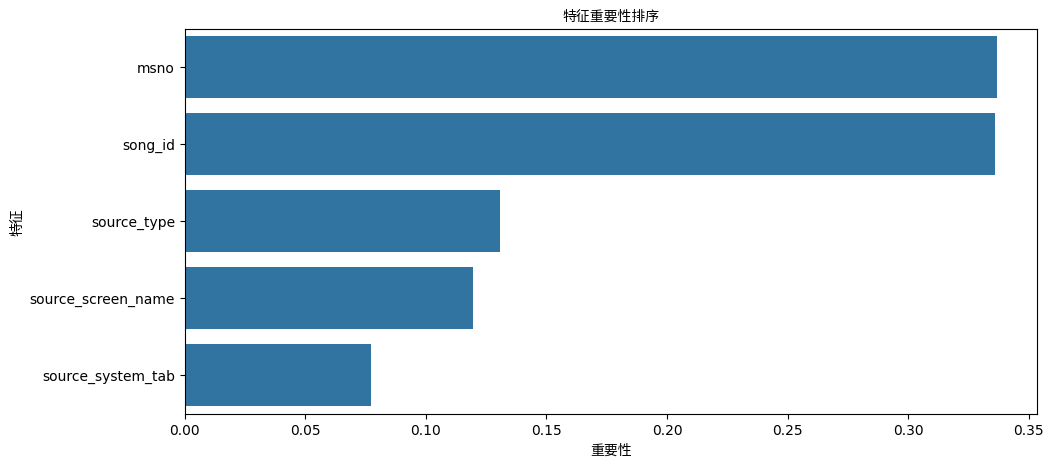

In [17]:
df_trains= df_train.sample(frac = 0.8)

model = ensemble.RandomForestClassifier(n_estimators=250, max_depth=25)
model.fit(df_trains[df_trains.columns[df_trains.columns != 'target']], df_trains.target)

df_plot = pd.DataFrame({'特征': df_trains.columns[df_trains.columns != 'target'],
                        '重要性': model.feature_importances_})
df_plot = df_plot.sort_values('重要性', ascending=False)
plt.figure(figsize=[11,5])
sns.barplot(x = df_plot['重要性'], y = df_plot['特征'])
plt.xlabel('重要性',fontproperties=ZHFONT)
plt.ylabel('特征',fontproperties=ZHFONT)
plt.title('特征重要性排序',fontproperties=ZHFONT)
plt.show()

## 用户歌曲对SVD

In [7]:
# 创建稀疏矩阵
df_train_grouped = df_train.groupby(['msno','song_id'])
df_train_grouped = df_train_grouped.size().reset_index(name='play_count')

user_song_sparse_matrix = sp.coo_matrix((df_train_grouped['play_count'], (df_train_grouped['msno'].astype('category').cat.codes, df_train_grouped['song_id'].astype('category').cat.codes)))

# SVD算法
K = 30
svd = TruncatedSVD(n_components=K)
user_song_svd = svd.fit_transform(user_song_sparse_matrix)
user_song_features = pd.DataFrame(user_song_svd, 
                                columns=[f'特征{i+1}' for i in range(K)],
                                index=df_train_grouped['msno'].astype('category').cat.categories)
display(user_song_features.head(15))

,特征1,特征2,特征3,特征4,特征5,特征6,特征7,特征8,特征9,特征10,特征11,特征12,特征13,特征14,特征15,特征16,特征17,特征18,特征19,特征20,特征21,特征22,特征23,特征24,特征25,特征26,特征27,特征28,特征29,特征30
0,5.285783,-1.303113,0.095960,1.110191,-0.615879,0.704021,2.090966,2.334840,2.239261,-0.531388,0.339376,1.430659,-1.591664,0.556470,-0.118751,0.645560,0.954629,-0.800923,0.185257,0.956304,-0.010508,0.548002,0.305654,0.239708,-0.125353,0.171566,-0.709353,0.914391,0.250200,-1.665869
1,4.763531,0.739429,-2.274537,0.987802,2.338821,-1.014221,-0.506134,0.153796,-0.616021,0.046828,0.496303,1.377852,-1.401089,0.173827,0.633955,-0.306459,-1.185915,-0.699268,0.000338,-0.571878,-0.119478,-0.411641,-0.215035,0.272701,-0.289958,-0.296447,1.057507,-0.720722,-0.030842,-0.370785
2,1.369755,-0.908749,-0.087355,0.638971,0.343659,0.166491,0.446069,0.196875,0.212665,-0.084477,-0.113851,0.071205,0.023137,-0.165543,0.487747,0.353380,0.108927,-0.449852,0.834508,-0.171812,0.063698,-0.230624,0.032029,0.240513,0.075003,0.467132,-0.316739,-0.011760,-0.235194,0.254119
3,0.448821,0.204225,0.651537,-0.388012,-0.429249,0.133587,0.002853,0.271105,-0.144818,-0.001155,-0.007756,0.178327,-0.190764,0.156525,-0.047690,-0.130129,0.326252,-0.034251,-0.015208,-0.122839,-0.256925,0.227353,-0.621002,-0.005905,0.174463,-0.072037,-0.032432,0.064552,-0.063606,0.068018
4,4.921730,0.997681,-1.156123,1.060706,-0.233445,2.536893,-2.256541,-1.131911,0.235655,0.821734,0.265460,0.076532,0.585204,-0.198686,-0.030733,0.723715,-1.289331,-0.024360,0.916788,0.325341,0.421987,0.280472,-0.822052,0.696920,0.500229,-1.052241,0.006266,-0.910463,-0.193191,-1.179576
5,0.251644,0.146448,0.121705,0.009264,-0.075695,0.077247,-0.102108,-0.202240,0.298813,0.066508,0.056608,0.087817,-0.003791,-0.009695,0.142996,0.017222,0.027940,0.025528,0.042800,0.050942,0.028794,-0.000691,0.203593,0.063295,-0.063026,0.080301,-0.035991,-0.151244,0.074876,-0.009056
6,0.575581,0.422909,-0.449302,0.031343,-0.091009,0.423222,0.148387,-0.342435,-0.039138,-0.138211,-0.220348,0.253154,-0.402664,-0.446853,0.267820,0.050938,-0.266783,0.219157,0.519704,-0.105809,0.757856,1.232244,0.670685,0.266333,0.815429,-0.264379,0.117903,0.547385,0.246554,0.299829
7,0.161369,-0.130166,-0.036683,0.100112,0.060063,-0.045975,0.147240,0.153473,-0.010238,0.022773,0.023716,0.049049,0.029826,-0.003085,0.099818,0.113666,0.030650,-0.024679,0.006257,0.006102,-0.020134,0.074893,-0.090102,0.044385,-0.055275,0.387015,0.116886,0.067007,-0.019290,-0.087653
8,0.523703,-0.186788,-0.175151,0.150636,0.054569,0.036745,0.013219,-0.134233,-0.078137,0.043611,-0.204853,-0.231374,-0.094755,0.198798,0.145164,-0.135367,-0.000381,-0.007222,0.092467,0.134682,0.016234,-0.240062,0.122405,-0.088393,0.025200,-0.073564,0.040487,0.044695,-0.015743,-0.115644
9,0.146914,-0.118416,-0.022685,0.025113,-0.008606,0.130366,0.351173,0.184354,0.161036,0.456008,-0.213713,-0.177840,0.122262,-0.202798,0.046626,-0.376582,-0.159128,0.051220,-0.020833,-0.005459,-0.020376,0.024914,0.024830,-0.097822,0.032684,-0.007988,0.047579,-0.013233,-0.040734,0.026427


In [8]:
# 计算每首歌曲的SVD向量表示
song_user_sparse_matrix = sp.coo_matrix((df_train_grouped['play_count'], (df_train_grouped['song_id'].astype('category').cat.codes, df_train_grouped['msno'].astype('category').cat.codes)))

# SVD算法
song_user_svd = svd.fit_transform(song_user_sparse_matrix)
song_user_features = pd.DataFrame(song_user_svd, 
                                columns=[f'特征{i+1}' for i in range(K)],
                                index=df_train_grouped['song_id'].astype('category').cat.categories)
display(song_user_features.head(15))

,特征1,特征2,特征3,特征4,特征5,特征6,特征7,特征8,特征9,特征10,特征11,特征12,特征13,特征14,特征15,特征16,特征17,特征18,特征19,特征20,特征21,特征22,特征23,特征24,特征25,特征26,特征27,特征28,特征29,特征30
0,0.000614,0.000372,0.000625,0.001416,0.000044,-0.002877,-0.002027,0.000665,0.002121,-0.000202,-0.001488,0.001475,-0.001884,-0.002086,-0.000612,0.000740,0.000838,-0.001778,0.001621,-0.000600,0.004056,0.000879,-0.000477,0.000699,0.000994,0.001128,-0.002137,-0.001577,-0.004482,-0.000949
1,0.004190,-0.009914,0.008302,-0.000312,0.004467,-0.010428,0.002493,0.006484,-0.003438,-0.000359,0.003407,0.001330,-0.003394,-0.013969,0.006955,-0.008027,0.004672,-0.005188,-0.002198,-0.001027,0.000548,0.004966,0.001245,-0.004406,-0.000505,-0.003305,-0.001024,-0.005196,-0.013569,0.000422
2,0.022389,-0.015675,-0.001101,0.006139,0.007675,-0.020455,-0.011599,0.022121,0.024196,0.019260,0.008028,-0.006683,0.002816,0.003790,0.040482,-0.022344,0.014175,-0.005670,0.001578,0.006760,0.011280,0.029431,-0.006436,0.036331,0.015807,-0.027231,-0.008233,-0.013657,-0.005801,0.022817
3,0.006691,0.011024,0.014827,0.008158,0.005873,-0.008516,-0.005045,0.006355,-0.001054,0.008187,0.016162,0.024690,-0.015368,-0.007772,-0.002653,0.009799,-0.003600,0.002813,-0.005066,0.000207,0.011753,0.004204,-0.017709,-0.005567,-0.012456,0.001930,-0.015175,-0.005739,-0.013485,0.007011
4,0.007840,0.006163,0.007367,0.002296,0.005739,-0.010531,-0.014719,0.011042,-0.005001,0.003074,0.002025,0.000644,-0.007544,-0.001244,0.007151,-0.005233,-0.007314,0.002272,-0.004073,0.004120,0.009681,0.001869,0.009875,-0.004114,-0.010099,-0.003839,-0.000298,-0.002137,-0.010755,0.006029
5,0.006633,0.003602,0.009856,-0.000062,0.006048,-0.008325,-0.013951,0.004024,0.002488,0.011237,0.004213,0.015551,-0.011047,-0.008536,0.002422,0.003328,-0.006314,0.006991,-0.003069,0.006494,0.005968,-0.002751,-0.005779,0.006010,-0.000246,-0.002804,-0.005597,-0.008495,-0.018047,0.005637
6,0.001180,-0.000440,-0.001893,0.002003,0.000738,0.002011,0.001205,0.002925,0.004221,0.004645,-0.001183,-0.001051,-0.002425,0.001896,0.001306,-0.000048,-0.003739,-0.000276,-0.000003,-0.005431,-0.003446,0.002095,0.001500,-0.003538,0.000704,0.001444,-0.003199,0.000232,-0.000812,-0.001604
7,0.475916,0.262387,0.056914,0.338183,0.235112,-0.118418,0.131774,-0.007924,0.276879,0.214808,0.224265,0.258765,-0.140607,0.162040,-0.118101,-0.209218,0.174356,0.147587,0.190542,-0.213659,-0.222139,0.089033,-0.170256,-0.101577,0.044629,-0.143901,-0.001548,0.478821,0.038190,0.329734
8,0.012836,0.006452,0.005306,-0.005211,-0.009096,-0.017550,-0.013764,0.003682,-0.002020,-0.010561,-0.000736,-0.004106,0.005795,-0.004439,0.007558,0.013685,0.016055,0.005755,-0.009839,-0.020639,0.011196,0.025387,0.001072,0.012452,0.007053,0.005274,-0.018221,-0.002753,-0.002047,-0.011153
9,0.011140,0.000728,0.004055,0.005620,-0.002806,0.006810,-0.005016,0.006321,0.002262,-0.015677,0.005017,0.007877,-0.012826,-0.017561,-0.000895,0.001685,-0.021163,-0.010547,-0.018580,-0.021239,0.005215,0.009781,0.019095,-0.022228,-0.013067,-0.000889,0.015426,-0.002185,-0.007605,-0.013960


## 将隐藏特征添加到train表中

In [9]:
# 保存处理后的数据集
user_song_features['msno'] = pd.Series(range(user_song_features.shape[0]))
song_user_features['song_id'] = pd.Series(range(song_user_features.shape[0]))

df_train = df_train.merge(user_song_features,how='inner',on='msno')
df_train = df_train.merge(song_user_features,how='inner',on='song_id')
display(df_train.head(15))

,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,composer,lyricist,language,name,isrc,特征1_x,特征2_x,特征3_x,特征4_x,特征5_x,特征6_x,特征7_x,特征8_x,特征9_x,特征10_x,特征11_x,特征12_x,特征13_x,特征14_x,特征15_x,特征16_x,特征17_x,特征18_x,特征19_x,特征20_x,特征21_x,特征22_x,特征23_x,特征24_x,特征25_x,特征26_x,特征27_x,特征28_x,特征29_x,特征30_x,特征1_y,特征2_y,特征3_y,特征4_y,特征5_y,特征6_y,特征7_y,特征8_y,特征9_y,特征10_y,特征11_y,特征12_y,特征13_y,特征14_y,特征15_y,特征16_y,特征17_y,特征18_y,特征19_y,特征20_y,特征21_y,特征22_y,特征23_y,特征24_y,特征25_y,特征26_y,特征27_y,特征28_y,特征29_y,特征30_y
0,8158,74631,1,7,6,1,206471,285,3277,14578,-1,52.0,51442,65234,23.120562,3.286560,-9.177410,-5.226779,-6.556179,-2.911717,7.557811,4.206898,6.556871,-9.532343,-7.811702,-0.899047,0.863799,9.780390,-0.794408,-2.488939,-6.431811,-3.239893,-4.746320,-1.033764,-2.269875,6.197968,0.950845,-4.821486,-3.719076,2.545588,0.739876,-2.078820,-1.084961,-2.244786,2.044803,-1.607482,1.313686,0.303596,0.904934,0.599028,-0.807153,0.295779,0.696466,-1.678166,1.112199,0.508658,0.533530,0.370156,0.312048,0.428916,0.771977,0.429838,0.482438,0.304147,0.055026,0.336757,0.565725,-0.124769,0.809856,-0.206215,-0.118553,-0.484581,1.490320,0.317354
1,17259,223347,3,8,4,1,284584,90,31950,-1,-1,52.0,81294,195646,9.598540,-3.096580,-4.304237,0.116798,1.152303,0.819182,-2.633169,0.373951,1.085736,-0.280250,0.567274,-0.530564,-0.861794,-1.866867,-0.736035,-0.633947,-0.023700,-0.070635,1.082495,-0.074476,-1.437774,-0.552819,0.730613,-2.923018,1.290901,-0.368991,-1.513183,0.138843,0.453483,0.898369,0.010330,0.008878,0.013911,-0.000462,-0.004890,-0.004429,0.014720,-0.002312,0.006869,-0.001864,-0.003809,0.003557,-0.006080,-0.014125,-0.005518,0.004965,0.000006,0.001001,-0.009351,0.000490,-0.010824,-0.005253,-0.010518,-0.025890,-0.011860,-0.003182,-0.012915,-0.002727,0.009434,-0.005535
2,17259,120686,3,8,4,1,225396,90,21365,45043,-1,52.0,57304,253595,9.598540,-3.096580,-4.304237,0.116798,1.152303,0.819182,-2.633169,0.373951,1.085736,-0.280250,0.567274,-0.530564,-0.861794,-1.866867,-0.736035,-0.633947,-0.023700,-0.070635,1.082495,-0.074476,-1.437774,-0.552819,0.730613,-2.923018,1.290901,-0.368991,-1.513183,0.138843,0.453483,0.898369,0.051098,0.032791,0.025347,0.023750,0.021027,0.011922,-0.003037,-0.014387,0.026315,-0.017531,0.025412,0.045428,0.019322,0.037356,-0.043197,-0.013855,0.044217,-0.013201,-0.005522,-0.031370,-0.033096,0.015651,0.025550,-0.069077,0.004290,-0.014128,-0.027919,-0.038926,0.031943,-0.025860
3,17259,23688,3,8,4,1,255512,6,27430,36688,-1,-1.0,34727,65562,9.598540,-3.096580,-4.304237,0.116798,1.152303,0.819182,-2.633169,0.373951,1.085736,-0.280250,0.567274,-0.530564,-0.861794,-1.866867,-0.736035,-0.633947,-0.023700,-0.070635,1.082495,-0.074476,-1.437774,-0.552819,0.730613,-2.923018,1.290901,-0.368991,-1.513183,0.138843,0.453483,0.898369,0.010330,0.008878,0.013911,-0.000462,-0.004890,-0.004429,0.014720,-0.002312,0.006869,-0.001864,-0.003809,0.003557,-0.006080,-0.014125,-0.005518,0.004965,0.000006,0.001001,-0.009351,0.000490,-0.010824,-0.005253,-0.010518,-0.025890,-0.011860,-0.003182,-0.012915,-0.002727,0.009434,-0.005535
4,8158,33284,1,7,6,1,187802,2,4472,8483,-1,52.0,121784,131924,23.120562,3.286560,-9.177410,-5.226779,-6.556179,-2.911717,7.557811,4.206898,6.556871,-9.532343,-7.811702,-0.899047,0.863799,9.780390,-0.794408,-2.488939,-6.431811,-3.239893,-4.746320,-1.033764,-2.269875,6.197968,0.950845,-4.821486,-3.719076,2.545588,0.739876,-2.078820,-1.084961,-2.244786,4.106430,-3.348634,1.694396,1.159042,1.724539,0.870475,-1.324039,0.159926,0.366045,-2.345175,0.960949,1.682344,2.261353,0.920948,1.965100,0.355883,0.923974,1.078141,1.089362,1.268001,-0.015458,0.304237,1.013699,-0.143134,1.039997,-0.455426,-0.987185,-0.696788,3.705228,1.171870
5,8158,30167,1,7,6,1,247803,90,8145,55559,-1,52.0,102613,259706,23.120562,3.286560,-9.177410,-5.226779,-6.556179,-2.911717,7.557811,4.206898,6.556871,-9.532343,-7.811702,-0.899047,0.863799,9.780390,-0.794408,-2.488939,-6.431811,-3.239893,-4.746320,-1.033764,-2.269875,6.197968,0.950

In [10]:
# import pyarrow as pa
# import pyarrow.csv as csv
# table = pa.Table.from_pandas(df_train)
# csv.write_csv(table, 'data/train_new.csv')